In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fuzzywuzzy import fuzz
import random
import matplotlib.pyplot as plt
from pprint import pprint

In [3]:
# Load movie dataset and ratings dataset
movies_df = pd.read_csv('./data/movies.csv')
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv('./data/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Combine movie titles and genres into a single string for content-based filtering
movies_df['combined'] = movies_df['title'].str.lower() + ' ' + movies_df['genres'].str.lower()

# Create a count vectorizer to convert the combined text to a matrix of word counts
count = CountVectorizer()
count_matrix = count.fit_transform(movies_df['combined'])

# Compute cosine similarity between movies based on the count matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Convert ratings to binary classes (e.g., "liked" and "not liked")
ratings_df['liked'] = (ratings_df['rating'] >= 4)  # Assuming 4 as the threshold for "liked"

# Split the ratings dataset into training and testing sets
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Train the collaborative filtering model using the training set
collaborative_model = LogisticRegression()  # Replace with your collaborative filtering model
collaborative_model.fit(train_ratings[['userId', 'movieId']], train_ratings['liked'])


LogisticRegression()

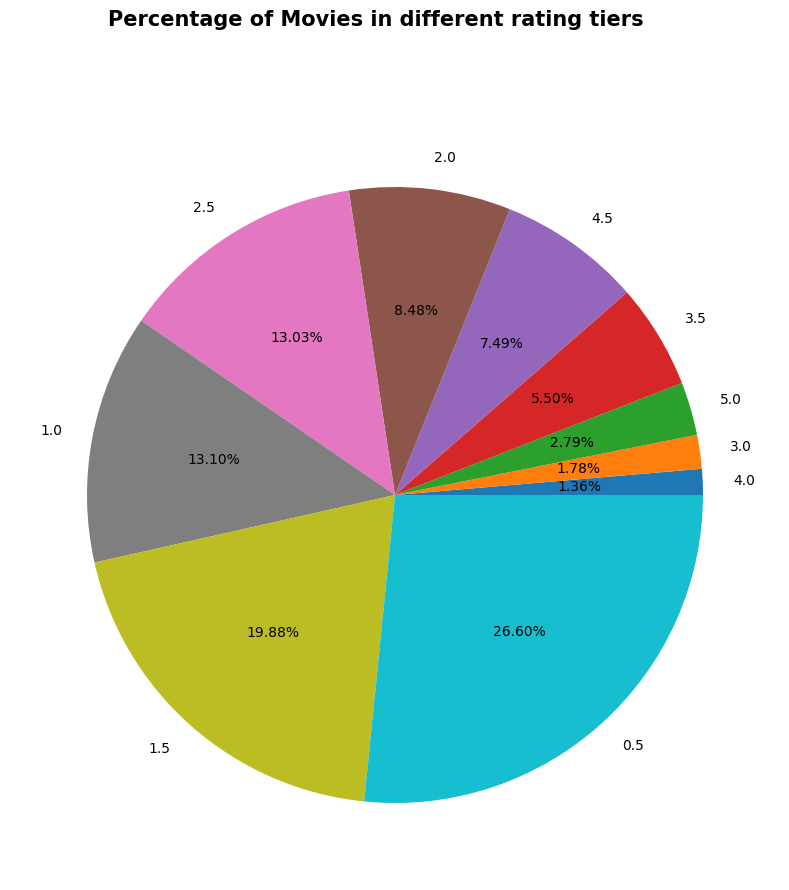

In [6]:
# we found that the column was not being read as int64 and some of the numbers in the 4000 range were being interpreted as date
# the movies with oddly formated IDs will be dropped during the join
movies_df['movieId'] = pd.to_numeric(movies_df['movieId'], errors='coerce').fillna(0)
movies_df["movieId"] = movies_df["movieId"].astype('int64')
#ratings_df = ratings_df['movieId'].apply(lambda x: x in movies_df['id'].tolist())
ratings_df = ratings_df[ratings_df['movieId'].apply(lambda x: x in movies_df['movieId'].tolist())]
df_combined = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='movieId', how='left')
figure = plt.figure(figsize=(15,10))
plt.pie(df_combined["rating"].value_counts().sort_values(), labels=df_combined["rating"].value_counts().index, autopct='%1.2f%%')
figure.suptitle('Percentage of Movies in different rating tiers', fontsize=15, fontweight='bold')
plt.show()

In [7]:
# Define a function to get the top N similar movies with some randomness
def get_content_based_recommendations(title, cosine_sim=cosine_sim, movies_df=movies_df, top_n=10):
    # Get the index of the movie that best matches the title using fuzzy matching
    matching_titles = movies_df[movies_df['title'].apply(lambda x: fuzz.partial_ratio(x.lower(), title.lower())) >= 80]
    if matching_titles.empty:
        print(f"Movie '{title}' not found in the dataset.")
        return []

    idx = matching_titles.index[0]

    # Compute the cosine similarity scores between the movie and all other movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Introduce randomness to the recommendations by shuffling the top N movies
    random.shuffle(sim_scores)

    # Get the top N similar movies
    sim_scores = sim_scores[:top_n]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

In [8]:
# Define a function to get recommendations using collaborative filtering
def get_collaborative_filtering_recommendations(user_id, model=collaborative_model, top_n=10):
    # Create a list of user-movie pairs for prediction
    user_movie_pairs = []
    user_movie_ids = movies_df['movieId'].unique()
    for movie_id in user_movie_ids:
        user_movie_pairs.append([user_id, movie_id])

    # Predict user's preferences for each movie using the collaborative filtering model
    user_predictions = model.predict_proba(user_movie_pairs)

    # Sort the predictions to get top N recommended movie indices
    movie_indices = user_movie_ids[user_predictions[:, 1].argsort()[::-1]][:top_n]

    return movies_df[movies_df['movieId'].isin(movie_indices)]['title']


In [9]:
# Get recommendations for a movie title and user ID
def get_recommendations(movie_title, user_id):
    content_based_recommendations = get_content_based_recommendations(movie_title)
    collaborative_recommendations = get_collaborative_filtering_recommendations(user_id=user_id)
    all_recommendations = list(content_based_recommendations) + list(collaborative_recommendations)
    random.shuffle(all_recommendations)
    return all_recommendations


# Get movie title and user ID from the user
def get_user_inputs():
    movie_title = input("Enter a movie title: ")
    user_id = int(input("Enter your user ID: "))
    return movie_title, user_id


In [10]:

# Example usage:
if __name__ == "__main__":
    movie_title, user_id = get_user_inputs()
    recommendations = get_recommendations(movie_title, user_id)
    print(f"Recommendations for '{movie_title}' and User ID '{user_id}':")
    for i, recommendation in enumerate(recommendations, 1):
        print(f"{i}. {recommendation}")

Recommendations for 'harry potter' and User ID '564':
1. Father of the Bride Part II (1995)
2. Riddick (2013)
3. Animal Farm (1954)
4. Buster's Mal Heart (2017)
5. Deconstructing Harry (1997)
6. Jury Duty (1995)
7. Sabrina (1995)
8. In the Army Now (1994)
9. Grumpier Old Men (1995)
10. Waiting to Exhale (1995)
11. GoldenEye (1995)
12. Jumanji (1995)
13. Toy Story (1995)
14. Scream 2 (1997)
15. Swept Away (2002)
16. Tom and Huck (1995)
17. Santa Clause 2, The (2002)
18. Sudden Death (1995)
19. Heat (1995)
20. Fire and Ice (1983)


f:\RaccoAI\Python\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
